In [17]:
# Prophet model for time series forecast
import prophet
import pyspark
import darts

# Data processing
import pandas as pd
import numpy as np
import csv

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from prophet import Prophet

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

#hmm needed? 
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

#darts
# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf


# Importing all functions in the "functions.py" file
#%run functions.py


%matplotlib inline
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


/home/coder/.local/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
#%run functions.py

Exception: File `'functions.py'` not found.

In [66]:
#Data preparation
data = pd.read_csv('life_expectancy.csv')


#Make datetime
data['Year'] = pd.to_datetime(data['Year'])

#Exclude entries that are not countries
exclude = ['Africa', 'Asia', 'Europe', 'High-income countries', 'Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World', 'Americas']

# Subset the DataFrame based on the countries of interest
data_countries = data.loc[~data['Country'].isin(exclude)]

# Rename Life expectancy column
data_countries.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)


#Transform dataset into TimeSeries
#Create ultiple time series by group
dataset_ts = TimeSeries.from_group_dataframe(df=data_countries, 
                                             group_cols=['Country'],
                                             time_col='Year', 
                                             value_cols='LE')


#Scale the target values
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()

#Scale the full dataset
dataset_ts_scaled = scaler.fit_transform(dataset_ts)

#Split in train, val, and test

#We set aside 75% for training - 54 years (1950-2004)
#And set asise 25% for testing - 17 years (2005-2021)

first_test_date = pd.Timestamp('2005-01-01')
train_dataset_ts, test_dataset_ts = [], []

for single_ts in tqdm(dataset_ts_scaled):
    # split into train and test tests
    single_train_ts, single_test_ts = single_ts.split_before(first_test_date)
    train_dataset_ts.append(single_train_ts)
    test_dataset_ts.append(single_test_ts)


/tmp/ipykernel_153/2602645260.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_countries.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)
/tmp/ipykernel_153/2602645260.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for single_ts in tqdm(dataset_ts_scaled):


  0%|          | 0/237 [00:00<?, ?it/s]

In [67]:
#Inspect columns
print(data_countries.columns)

Index(['Country', 'Year', 'LE'], dtype='object')


<AxesSubplot:xlabel='Year', ylabel='LE'>

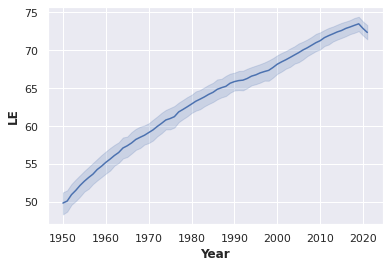

In [6]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data_countries['Year'], y=data_countries['LE'])

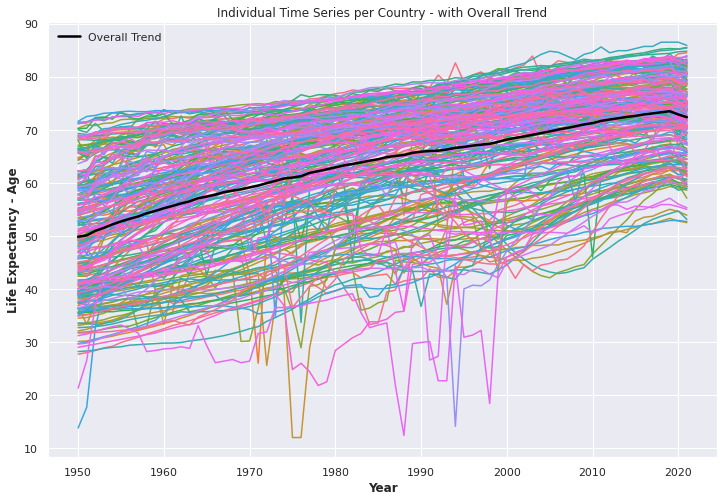

In [68]:
# Set the figure size
sns.set(rc={'figure.figsize':(12,8)})

# Plotting individual time series per country with overlapping lines and no legend
sns.lineplot(x='Year', y='LE', hue='Country', data=data_countries, legend=False)

# Calculate the overall trend (e.g., average)
overall_trend = data_countries.groupby('Year')['LE'].mean()

# Plot the overall trend line
plt.plot(overall_trend.index, overall_trend, color='black', linestyle='-', lw=2.5, label='Overall Trend')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Life Expectancy - Age')
plt.title('Individual Time Series per Country - with Overall Trend')
plt.grid(True)
plt.legend()
plt.show()


In [69]:
#Data processing
data = pd.read_csv('life_expectancy.csv')

#Exclude entries that are not countries
exclude = ['Africa', 'Asia', 'Europe', 'High-income countries', 'Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World', 'Americas']

# Subset the DataFrame based on the countries of interest
data_countries_1 = data.loc[~data['Country'].isin(exclude)]

# Rename Life expectancy column
data_countries_1.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)


#data_countries_1['Year'] = pd.to_datetime(data_countries_1['Year'])


#data_countries_1['Country'] = label_encoder.fit_transform(data_countries_1['Country'])

#Pivot data differently
pivoted_data = data_countries_1.pivot(index='Country', columns='Year', values='LE')

#Convert data to matrix
data_matrix = pivoted_data.values


/tmp/ipykernel_153/233064663.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_countries_1.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)


In [70]:
# Checking unique countries
unique_countries = data_countries_1['Country'].unique()
print(unique_countries)

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cuba' 'Curacao' 'Cyprus' 'Czechia'
 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Faeroe Islands'
 'Falkland Islands' 'Fiji' 'Finland' 'France' 'French Guiana'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Gibral

## Trying new method

#### Deciding the best number of clusters

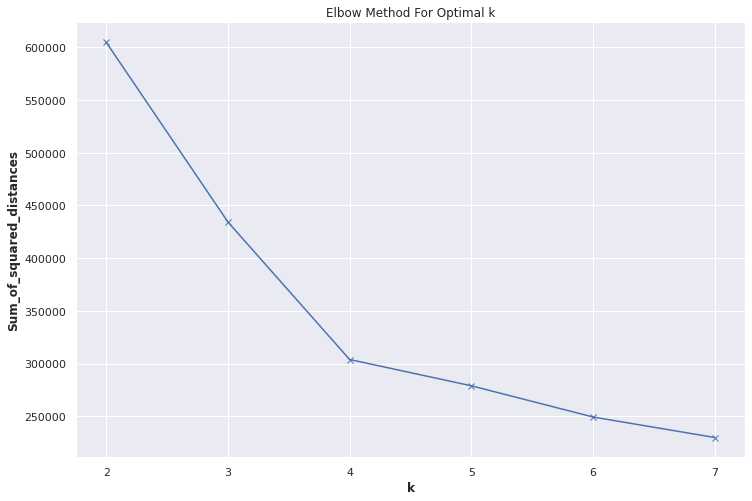

In [71]:
## Deciding how many clusters to use
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = BisectingKMeans(n_clusters=k,
                          n_init=2,
                          verbose=False,
                          bisecting_strategy = "biggest_inertia")
    
    km = km.fit(time_series)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems like the optimal number of clusters is 4. After this, the sum of squared distances is not decreasing much as K increases

#### Performing the clustering

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans
from datetime import datetime

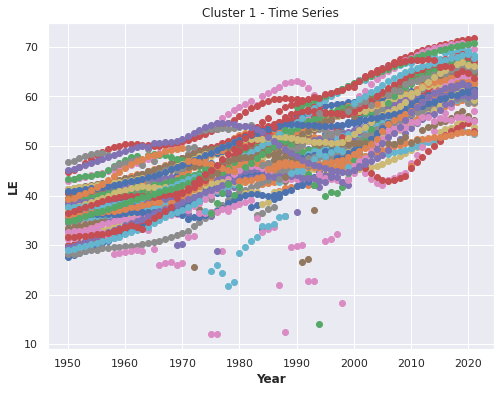

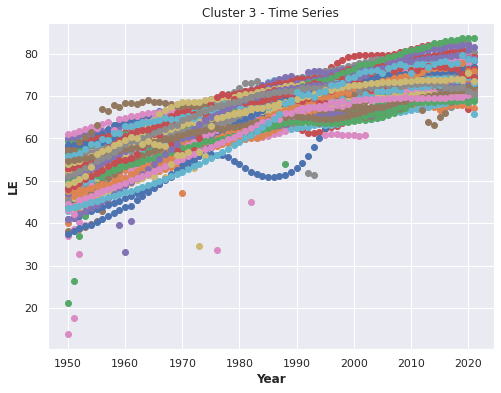

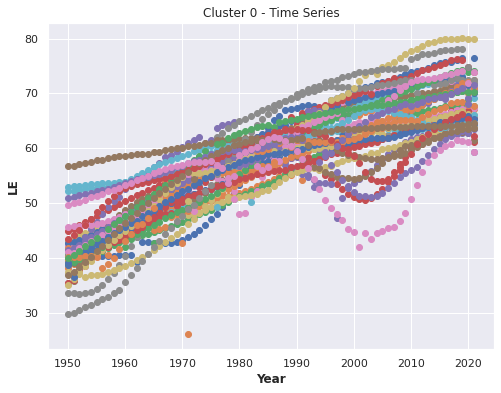

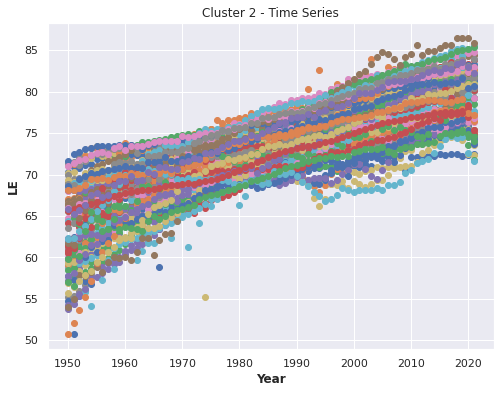

In [72]:
#correct  columns structure - wide
np.random.seed(45)  # Set the random seed to 42

# Pivot data differently to preserve individual time series
pivoted_data = data_countries_1.pivot(index='Country', columns='Year', values='LE')

# Convert the pivot data to a list of time series
time_series = pivoted_data.values.tolist()

# Build and fit the model on the list of time series
bisect_means = BisectingKMeans(n_clusters=4, bisecting_strategy = "biggest_inertia").fit(time_series)

# Get the cluster labels and cluster centers
labels = bisect_means.labels_
centers = bisect_means.cluster_centers_

# Create a dictionary to store the clustered data
clustered_data = {}

# Iterate over each country and its corresponding label
for country, label in zip(pivoted_data.index, labels):
    # Check if the cluster label is already in the dictionary
    if label in clustered_data:
        # Append the country's time series and label to the existing cluster
        clustered_data[label].append((country, pivoted_data.loc[country]))
    else:
        # Create a new cluster and store the country's time series and label
        clustered_data[label] = [(country, pivoted_data.loc[country])]

# Save the clustered data to separate CSV files and create scatter plots
for label, data in clustered_data.items():
    # Extract the time series data
    time_series_data = [ts for _, ts in data]
    
    # Create a DataFrame to store the clustered data with country labels and columns from time_series_data
    cluster_df = pd.DataFrame(time_series_data, columns=pivoted_data.columns)
    cluster_df.insert(0, 'Country', [country for country, _ in data])
    
    # Create a file for each cluster
    filename = f"wide_cluster_{label}_full.csv"
    
    # Save the cluster data to a CSV file
    cluster_df.to_csv(filename, index=False)
    
    # Create a scatter plot for each cluster
    plt.figure(figsize=(8, 6))
    for _, ts in data:
        # Convert date strings to datetime objects and extract the year
        x = [datetime.strptime(date, '%Y-%m-%d').year for date in ts.index]
        plt.scatter(x, ts.values)
    
    # Set x-axis ticks to display every 10 years
    x_ticks = np.arange(x[0], x[-1]+1, 10)
    plt.xticks(x_ticks)
    
    plt.title(f"Cluster {label} - Time Series")
    plt.xlabel("Year")
    plt.ylabel("LE")
    plt.show()


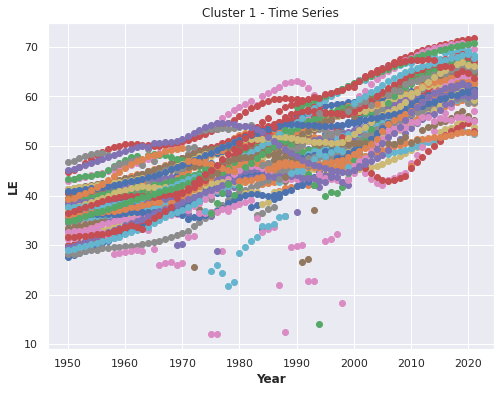

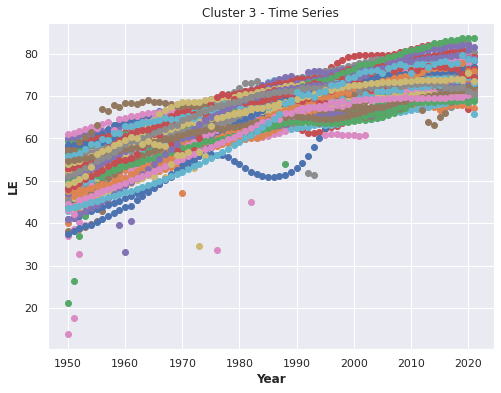

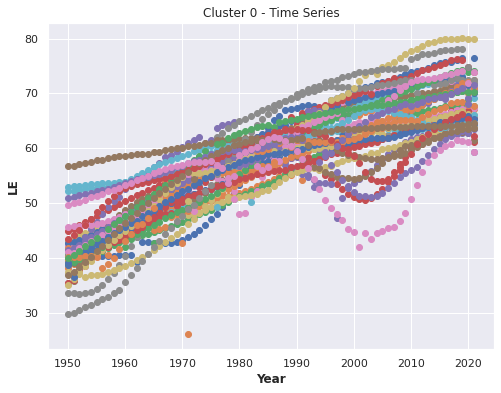

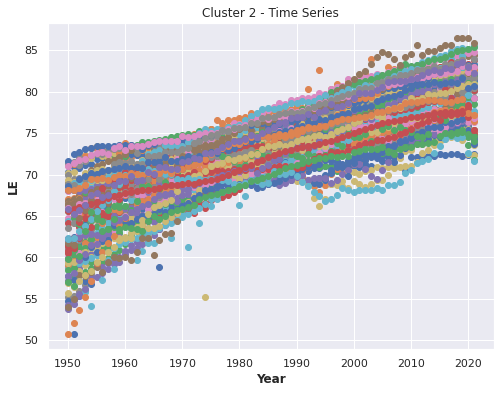

In [73]:
# Long format
np.random.seed(45)

# Pivot data differently to preserve individual time series
pivoted_data = data_countries_1.pivot(index='Country', columns='Year', values='LE')

# Convert the pivot data to a list of time series
time_series = pivoted_data.values.tolist()

# Build and fit the model on the list of time series
bisect_means = BisectingKMeans(n_clusters=4, bisecting_strategy="biggest_inertia").fit(time_series)

# Get the cluster labels and cluster centers
labels = bisect_means.labels_
centers = bisect_means.cluster_centers_

# Create a dictionary to store the clustered data
clustered_data = {}

# Iterate over each country and its corresponding label
for country, label in zip(pivoted_data.index, labels):
    # Check if the cluster label is already in the dictionary
    if label in clustered_data:
        # Append the country's time series and label to the existing cluster
        clustered_data[label].append((country, pivoted_data.loc[country]))
    else:
        # Create a new cluster and store the country's time series and label
        clustered_data[label] = [(country, pivoted_data.loc[country])]

# Save the clustered data to separate CSV files and create scatter plots
for label, data in clustered_data.items():
    # Create a list to store the long format data rows
    long_data = []

    for country, ts in data:
        # Convert date strings to datetime objects and extract the year
        years = [datetime.strptime(date, '%Y-%m-%d').year for date in ts.index]

        # Append the long format data for each year to the list
        long_data.extend(zip([country]*len(years), years, ts.values))

    # Create a DataFrame from the long format data
    long_df = pd.DataFrame(long_data, columns=['Country', 'Year', 'LE'])

    # Create a file for each cluster
    filename = f"long_cluster_{label}_full.csv"

    # Save the long format data to a CSV file
    long_df.to_csv(filename, index=False)

    # Create a scatter plot for each cluster
    plt.figure(figsize=(8, 6))
    for _, ts in data:
        # Convert date strings to datetime objects and extract the year
        x = [datetime.strptime(date, '%Y-%m-%d').year for date in ts.index]
        plt.scatter(x, ts.values)

    # Set x-axis ticks to display every 10 years
    x_ticks = np.arange(x[0], x[-1] + 1, 10)
    plt.xticks(x_ticks)

    plt.title(f"Cluster {label} - Time Series")
    plt.xlabel("Year")
    plt.ylabel("LE")
    plt.show()


#### Ensuring no countries are assigned to more clusters
This might however  not be desireable, since the point of each cluster is just to perform the cluster forecasting method, and not to describe the data

In [11]:
#Only one cluster per country
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.cluster import BisectingKMeans

# # Pivot data differently to preserve individual time series
# pivoted_data = data_countries_1.pivot(index='Country', columns='Year', values='LE')

# # Convert the pivot data to a list of time series
# time_series = pivoted_data.values.tolist()

# # Build and fit the model on the list of time series
# bisect_means = BisectingKMeans(n_clusters=5).fit(time_series)

# # Get the cluster labels and cluster centers
# labels = bisect_means.labels_
# centers = bisect_means.cluster_centers_

# # Create a dictionary to store the clustered data
# clustered_data = {}

# # Iterate over each country and its corresponding label
# for country, label in zip(pivoted_data.index, labels):
#     # Check if the country has already been assigned to a cluster

#     assigned_cluster = None
#     for cluster_label, data in clustered_data.items():
#         for _, ts in data:
#             if country == _:
#                 assigned_cluster = cluster_label
#                 break
    
#     if assigned_cluster is not None:
#         # Country is already assigned to a cluster, skip it
#         continue

#     # Append the country's time series and label to the existing cluster
#     if label in clustered_data:
#         clustered_data[label].append((country, pivoted_data.loc[country]))
#     else:
#         # Create a new cluster and store the country's time series and label
#         clustered_data[label] = [(country, pivoted_data.loc[country])]

# # Save the clustered data to separate CSV files and create scatter plots
# for label, data in clustered_data.items():
#     # Create a DataFrame to store the clustered data with country labels
#     cluster_df = pd.DataFrame(data, columns=['Country', 'TimeSeries'])
    
#     # Create a file for each cluster
#     filename = f"cluster_{label}_data.csv"
    
#     # Save the cluster data to a CSV file
#     cluster_df.to_csv(filename, index=False)
    
#     # Create a scatter plot for each cluster
#     plt.figure(figsize=(8, 6))
#     for _, ts in data:
#         plt.scatter(ts.index, ts.values)
#     plt.title(f"Cluster {label} - Time Series")
#     plt.xlabel("Year")
#     plt.ylabel("LE")
#     plt.show()


### Doing the actual forecasting on one cluster
Fitting a univariate time series model to a cluster of series

In [113]:
# Loading the first cluster
# folder_path = '/work/Data Science Exam/clustered_data'  # Replace with the actual folder path
# file_name = 'long_cluster_2_full.csv'

import pandas as pd
from darts import TimeSeries

clus2 = pd.read_csv('/work/Data Science Exam/clustered_data/long_cluster_2_full.csv', parse_dates=['Year'])

# Set the first_test_date within the valid range
first_test_date = pd.Timestamp('2005-01-01')

clus2_ts = TimeSeries.from_group_dataframe(df=clus2, 
                                           group_cols=['Country'],
                                           time_col='Year', 
                                           value_cols='LE')

train_clus2_ts, test_clus2_ts = [], []

for single_ts in clus2_ts:
    # split into train and test tests
    single_train_ts, single_test_ts = single_ts.split_before(first_test_date)
    train_clus2_ts.append(single_train_ts)
    test_clus2_ts.append(single_test_ts)



In [122]:
# Doing it with data frames instead
first_test_date = pd.Timestamp('2005-01-01')

train_clus2, test_clus2 = [], []

# Group the data by 'Country' column
grouped = clus2.groupby('Country')

# Iterate over each group
for _, group_data in grouped:
    # Sort the group data by the 'Year' column
    group_data = group_data.sort_values('Year')

    # Split the data based on the first_test_date
    train_data = group_data[group_data['Year'] < first_test_date]
    test_data = group_data[group_data['Year'] >= first_test_date]

    # Append the train and test data to the respective sets
    train_clus2.append(train_data)
    test_clus2.append(test_data)


#### Compute the representative time series for cluster 2
By taking yearly aggregation across all the individual series.

In [126]:
#Yearly aggregation across all individual ts
# Concatenate the list of DataFrames into a single DataFrame
train_df = pd.concat(train_clus2)

# Perform the yearly aggregation across all individual time series
agg_df_train = train_df.groupby('Year')['LE'].median().reset_index()

agg_df_train.rename({'Year':'ds', 'LE':'y'}, axis=1,inplace=True)

#define and fit model
model = Prophet(
growth='linear',
seasonality_mode= 'additive',
yearly_seasonality=False,
weekly_seasonality=False,
daily_seasonality=False
)
model.fit(agg_df_train)

In [152]:
# Generate forecasts on the test period for the median time series
test_df = pd.concat(test_clus2)
agg_df_test = test_df.groupby('Year')['LE'].median().reset_index()

agg_df_test.rename({'Year':'ds', 'LE':'y'}, axis=1,inplace=True)
predictions = model.predict(df=agg_df_test.drop('y', axis=1))


In [157]:
# compute the adjustment series in the training period, and then build a simple linear model to forecast for the test period.

# Merge train_df with aggregated df
train_df = train_df.merge(agg_df_train[['ds', 'y']], right_on='ds', left_on=date_col, how='left')

#Compute adjustment series
train_df['delta_val'] = train_df['LE']-train_df['y']

#Merge predictions and test set
test_df = test_df.merge(predictions[['ds', 'yhat']], left_on=date_col, right_on='ds', how='left')

df_actual_all = pd.concat([train_df, test_df])

/tmp/ipykernel_153/595835658.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ds_x', 'y_x'} in the result is deprecated and will raise a MergeError in a future version.
  train_df = train_df.merge(agg_df_train[['ds', 'y']], right_on='ds', left_on=date_col, how='left')


KeyError: 'y'

In [181]:
# compute the adjustment series in the training period, and then build a simple linear model to forecast for the test period.

# Merge train_df with aggregated df
#train_df = train_df.merge(agg_df_train[['ds', 'y']], right_on='ds', left_on = 'Year', how='left')

train_df.columns

Index(['Country', 'Year', 'LE', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds_x', 'y_x',
       'delta_val', 'ds_y', 'y_y', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds_x', 'y_x',
       'ds_y', 'y_y', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds_x', 'y_x', 'ds_y',
       'y_y', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds_x', 'y_x', 'ds_y', 'y_y',
       'ds_train', 'y_train', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds_x', 'y_x',
       'ds_y', 'y_y', 'ds_left', 'y_left', 'ds_right', 'y_right', 'y'],
      dtype='object')

In [176]:
#Compute adjustment series
train_df['delta_val'] = train_df['LE']-train_df['y']

In [177]:
#Merge predictions and test set
test_df = test_df.merge(predictions[['ds', 'yhat']], left_on= 'Year', right_on='ds', how='left')

KeyError: 'Year'

In [ ]:
df_actual_all = pd.concat([df_train, df_test])

In [160]:

def get_linear_model_pred(train_test_df, test_dat):
  from sklearn.linear_model import LinearRegression
  train_test_df = train_test_df.sort_values(date_col).reset_index(drop=True)
  train_test_df['t'] = np.arange(0, train_test_df.shape[0])
  train_test_df['t2'] = train_test_df['t']**2
  train_df = train_test_df.loc[~train_test_df[date_col].astype(str).isin(test_dat['ds'].astype(str).values.tolist())].reset_index(drop=True)
  test_df = train_test_df.loc[train_test_df[date_col].astype(str).isin(test_dat['ds'].astype(str).values.tolist())].reset_index(drop=True)
  lm_obj = LinearRegression().fit(train_df[features_to_use+['t', 't2']],train_df[['delta_val']])
  test_delta_pred = lm_obj.predict(test_df[features_to_use+['t', 't2']])
  return pd.DataFrame({'month': test_df[date_col].values,'test_delta_pred' : test_delta_pred[:,0]})


In [161]:
test_df_delta = df_actual_all.groupby(['id_nbr']).apply(lambda x: get_linear_model_pred(x, agg_df_test)).reset_index(drop=False)


df_test = df_test.merge(test_df_delta[['id_nbr', date_col, 'test_delta_pred']], on=['id_nbr', date_col], how='left')




KeyError: 'id_nbr'

In [166]:
df_actual_all.columns

Index(['Country', 'Year', 'LE', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds_x', 'y_x',
       'delta_val', 'ds_y', 'y_y', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds_x', 'y_x',
       'ds_y', 'y_y', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds_x', 'y_x', 'ds_y',
       'y_y', 'ds_x', 'y_x', 'ds_y', 'y_y', 'ds', 'y', 'Country_test',
       'Year_test', 'LE_test', 'ds_x_test', 'yhat_x_test', 'ds_y_test',
       'yhat_y_test', 'ds_test', 'yhat_test'],
      dtype='object')